
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.


# Projet final : Débordement d'égouts
### Équipe 17 : Elie Rouphael, Souhaila Mellouk, Thien-Kim Luu, Mourad Younes, Chararbsissy Lynn
Remis le vendredi 20 décembre

# Introduction

Le but de ce projet consiste à déterminer les caractéristiques des événements pluvieux susceptibles de générer des surverses sur le territoire de la Ville de Montréal. Il s'agit d'établir le lien entre les événements pluvieux et les surverses dues aux précipitations. On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

In [106]:
using Distributions

In [107]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Missings

# Chargement des données et nettoyage préliminaire

## Chargement des surverses

In [108]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


## Nettoyage des données sur les surverses

#### Extraction des surverses pour les mois de mai à octobre inclusivement

In [109]:
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


#### Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"

In [110]:
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String
1,0642-01D,2013-05-01,0,Inconnue
2,0642-01D,2013-05-02,0,Inconnue
3,0642-01D,2013-05-03,0,Inconnue
4,0642-01D,2013-05-04,0,Inconnue
5,0642-01D,2013-05-05,0,Inconnue


#### Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides

Ces facteurs correspondent à : 
- la fonte de neige (F), 
- les travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

In [111]:
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64⍰
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0
6,0642-01D,2013-05-06,0
7,0642-01D,2013-05-07,0
8,0642-01D,2013-05-08,0
9,0642-01D,2013-05-09,0


#### Exclusion des lignes où :SURVERSE est manquante

In [112]:
surverse_df = dropmissing(data, disallowmissing=true);

In [113]:
n₁ = sum(x->x==1, surverse_df[:SURVERSE], dims=1) 
n₀ = sum(x->x==0, surverse_df[:SURVERSE], dims=1) 
n = n₀ + n₁

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[113]:1
└ @ Core In[113]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[113]:2
└ @ Core In[113]:2


1-element Array{Int64,1}:
 161098

In [114]:
filtervals = ["3260-01D"; "3350-07D"; "4240-01D"; "4350-01D"; "4380-01D"]
surverse_df1 = filter(row-> row.NO_OUVRAGE == filtervals[1], surverse_df)
surverse_df2 = filter(row-> row.NO_OUVRAGE == filtervals[2], surverse_df)
surverse_df3 = filter(row-> row.NO_OUVRAGE == filtervals[3], surverse_df)
surverse_df4 = filter(row-> row.NO_OUVRAGE == filtervals[4], surverse_df)
surverse_df5 = filter(row-> row.NO_OUVRAGE == filtervals[5], surverse_df);

In [115]:
#### on prend pour chaque ouvrage le nombre de fois ou il a eu surver et non
n₁ = Int64[]
n₀  = Int64[]
n  = Int64[]

0-element Array{Int64,1}

In [116]:

function findSurverseCount(surverse_df1)
    n1₁ = sum(x->x==1, surverse_df1, dims=1) 
    push!(n₁, n1₁[1])
    n1₀ = sum(x->x==0, surverse_df1, dims=1)  
    push!(n₀, n1₀[1])
    n1= n1₁[1] + n1₀[1]
    push!(n, n1)
end

findSurverseCount (generic function with 1 method)

In [117]:
findSurverseCount(surverse_df1[:SURVERSE]);
findSurverseCount(surverse_df2[:SURVERSE]);
findSurverseCount(surverse_df3[:SURVERSE]);
findSurverseCount(surverse_df4[:SURVERSE]);
findSurverseCount(surverse_df5[:SURVERSE]);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[117]:1
└ @ Core In[117]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[117]:2
└ @ Core In[117]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[117]:3
└ @ Core In[117]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[117]:4
└ @ Core In[117]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[117]:5
└ @ Core In[117]:5


## Chargement des précipitations

In [118]:
databefore = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(databefore, Symbol("St-Hubert")=>:StHubert)
first(databefore,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-01-01,0,0,0,0,0,missing
2,2013-01-01,1,0,0,0,0,missing
3,2013-01-01,2,0,0,0,0,missing
4,2013-01-01,3,0,0,0,0,missing
5,2013-01-01,4,0,0,0,0,missing


In [119]:
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert)
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-01-01,0,0,0,0,0,missing
2,2013-01-01,1,0,0,0,0,missing
3,2013-01-01,2,0,0,0,0,missing
4,2013-01-01,3,0,0,0,0,missing
5,2013-01-01,4,0,0,0,0,missing


## Nettoyage des données sur les précipitations

#### Extraction des précipitations des mois de mai à octobre inclusivement

In [120]:
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data) 
databefore = filter(row -> month(row.date) > 3, databefore) 
databefore = filter(row -> month(row.date) < 11, databefore) 
databefore = filter(row -> row.heure >= 19, databefore) ;

In [121]:
function fillWithMean(table)
    
    for j=1:size(table,1)
        means = 0
        sum = 0
        alo = names(table)
        for col in alo
            if col != alo[1]
                if !ismissing(table[j, col]) 
                    sum = sum +1
                    means = means + table[j, col]
                end
            end
        end
        if sum != 0
            means = means / sum
        end
        for col in alo
            if ismissing(table[j, col]) && col != alo[1]
                tests = floor(means)
                table[j, col] = floor(tests)
            end
        end
    end
end

fillWithMean (generic function with 1 method)

In [122]:
fillWithMean(data)
fillWithMean(databefore)

In [123]:
pcp_sum = by(data, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum);
first(pcp_sum ,5);

In [124]:
pcp_max = by(data, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5);

In [125]:
pcp_sumBefore = by(databefore, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum);
first(pcp_sum ,5);

In [126]:
pcp_maxBefore = by(databefore, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5);

# Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de voir s'il existe un lien entre les précipitations et les surverses.

Prenons arbitrairement l'ouvrage de débordement près du Bota-Bota (4350-01D). La station météorologique la plus proche est McTavish. Prenons deux variables explicatives simple :
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations

#### Calcul de la quantité journalière de précipitations pour chacune des stations météorologiques

In [127]:
function findMeanOfAllColumn(table)
    p = DataFrame(name =Float64[])
    for j=1:size(table,1)
        alo = names(table)
        means = 0
        sum = 0
        for col in alo
            if col != alo[1]
                if !ismissing(table[j, col]) 
                    sum = sum +1
                    means = means + table[j, col]
                end
            end
        end
        push!(p, means/sum)
    end
    table = DataFrame(date = table[:date]; name =p[:name]);
    return table
end

findMeanOfAllColumn (generic function with 1 method)

In [128]:
CSV.write("pcp_max_before.csv",pcp_max)
CSV.write("pcp_sum_before.csv",pcp_sum)

"pcp_sum_before.csv"

#### Inclusion dans un dataframe de ces deux variables explicatives potentielles

**Tableau 1. Distances entre les stations pluviométriques et les lieux des ouvrages**

|  | McTavish | Ste-Anne-de-Bellevue | Montréal/Pierre Elliott Trudeau Intl | Montréal/St-Hubert | L’Assomption |
|----------|----------|----------|----------|----------|----------|
| Rivière-des-Prairies | 16,56 km | 37,31 km | 24,05 km | 19,91 km | 20,98 km 
| Ahunstic | 10,00 km | 23,21 km | 9,69 km | 21,68 km | 35,44 km |
| Pointe-aux-Trembles | 17,67 km | 42,82 km | 28,37 km | 15,68 km | 18.19 km |
| Vieux-Montréal | 2,16 km | 30,66 km | 15,18 km | 10,74 km | 35,60 km |
| Verdun | 4,29 km | 29,58 km | 14,45 km | 12,10 km | 38,95 km |


Ces distances ont été trouvé à l'aide de Google Map.

**calculateMeanUsingDistance** mets dans une table la moyenne des surverses des stations les plus proches en fonction des ouvragres

@params une table (ex: pcp_sum, pcp_max ...) 

@return une table

In [129]:
function calculateMeanUsingDistance(table)
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :StHubert], Assomption=table[:, :Assomption]);
    S4240 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :StHubert], Assomption=table[:, :Assomption]);
    S3260 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish]);
    S4350_4380 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :Trudeau]);
    S3350 = findMeanOfAllColumn(p);
    
    return DataFrame(date = table[:, :date],S4240=S4240[:name], S3260=S3260[:name],S4350_4380=S4350_4380[:name],S3350=S3350[:name] );
end

calculateMeanUsingDistance (generic function with 1 method)

In [130]:
pcp_sum = calculateMeanUsingDistance(pcp_sum)
pcp_max = calculateMeanUsingDistance(pcp_max)
pcp_sumBefore = calculateMeanUsingDistance(pcp_sumBefore)
pcp_maxBefore = calculateMeanUsingDistance(pcp_maxBefore)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = findMeanOfAllColumn(::DataFrame) at In[127]:17
└ @ Main .\In[127]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = findMeanOfAllColumn(::DataFrame) at In[127]:17
└ @ Main .\In[127]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[129]:11
└ @ Main .\In[129]:11
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[129]:11
└ @ Main .\In[129]:11
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[129]:11
└ @ Main .\In[129]:11
┌ Warning: `getindex(df::DataFrame, col_ind::Colu

,date,S4240,S3260,S4350_4380,S3350
,Date,Float64,Float64,Float64,Float64
1,2013-04-01,1.33333,1.33333,0.0,0.0
2,2013-04-02,1.33333,1.33333,0.0,0.0
3,2013-04-03,1.33333,1.33333,0.0,0.0
4,2013-04-04,1.33333,1.33333,0.0,0.0
5,2013-04-05,1.33333,1.33333,0.0,0.0
6,2013-04-06,1.33333,1.33333,0.0,0.0
7,2013-04-07,9.33333,9.33333,0.0,0.0
8,2013-04-08,1.33333,1.33333,0.0,0.0
9,2013-04-09,1.33333,1.33333,0.0,0.0


In [131]:
filtervals = ["3260-01D"; "3350-07D"; "4240-01D"; "4350-01D"; "4380-01D"];
table = ["S3260", "S3350","S4240","S4350_4380", "S4350_4380"];

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[132]:15
└ @ Core In[132]:15
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[132]:15
└ @ Core In[132]:15
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[132]:15
└ @ Core In[132]:15


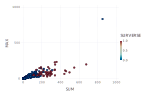

In [132]:
j=1
dfSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j] , surverse_df)
sums = DataFrame(SUM =Float64[])
maxs = DataFrame(MAX =Float64[])
surverse = DataFrame(surverse =Int64[])
for i=1:size(dfSurverse,1)
    ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
    push!(sums, pcp_sum[ind,Symbol(table[j])])

    indmax = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
    push!(maxs, pcp_max[indmax, Symbol(table[j])])
    
    push!(surverse, dfSurverse[i,:SURVERSE])
end
            
table = DataFrame(SUM = sums[:SUM], MAX =maxs[:MAX],SURVERSE= surverse[:surverse]);
plot(table, x="SUM", y="MAX",color="SURVERSE",  Geom.point)

In [133]:
moyenneSumSurverses = Float64[]
moyenneMaxSurverses = Float64[]
varianceSumSurverses = Float64[];
varianceMaxSurverses = Float64[];

moyenneSumNonSurverses = Float64[]
moyenneMaxNonSurverses = Float64[]
varianceSumNonSurverses = Float64[]
varianceMaxNonSurverses = Float64[]
for j=1:size(filtervals,1)
    dfSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j]  && row.SURVERSE ==1, surverse_df)
    dfNonSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j]  && row.SURVERSE ==0, surverse_df)


    moyenneSumSurverse = 0;
    moyenneMaxSurverse = 0;
    for i=1:size(dfSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
        moyenneSumSurverse += pcp_sum[ind,Symbol(table[j])]
        
        indmax = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
        moyenneMaxSurverse +=  pcp_max[indmax,Symbol(table[j])]
    end
    moyenneSumSurverse = moyenneSumSurverse / size(dfSurverse,1)
    push!(moyenneSumSurverses, moyenneSumSurverse)
    moyenneMaxSurverse = moyenneMaxSurverse / size(dfSurverse,1)
    push!(moyenneMaxSurverses, moyenneMaxSurverse)
    
    moyenneSumNonSurverse = 0;
    moyenneMaxNonSurverse = 0;
    for i=1:size(dfNonSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfNonSurverse[i,:DATE])
        moyenneSumNonSurverse = moyenneSumNonSurverse +  pcp_sum[ind,Symbol(table[j])]
        
        ind = findfirst(pcp_max[:,:date] .== dfNonSurverse[i,:DATE])
        moyenneMaxNonSurverse = moyenneMaxNonSurverse +  pcp_max[ind,Symbol(table[j])]
    end
    moyenneSumNonSurverse /= size(dfNonSurverse,1)
    push!(moyenneSumNonSurverses, moyenneSumNonSurverse)
    moyenneMaxNonSurverse /= size(dfNonSurverse,1)
    push!(moyenneMaxNonSurverses, moyenneMaxNonSurverse)
    
    
    
    #### maintenant la variance
    varianceSumSurverse = 0;
    varianceMaxSurverse = 0;
    for i=1:size(dfSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
        varianceSumSurverse += (pcp_sum[ind,Symbol(table[j])]-moyenneSumSurverse)^2

        ind = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
        varianceMaxSurverse += (pcp_max[ind,Symbol(table[j])]-moyenneMaxSurverse)^2
        
       
    end
    varianceSumSurverse /= size(dfSurverse,1)
    push!(varianceSumSurverses, varianceSumSurverse)
    varianceMaxSurverse /= size(dfSurverse,1)
    push!(varianceMaxSurverses, varianceMaxSurverse)

    
    varianceSumNonSurverse = 0;
    varianceMaxNonSurverse = 0;
    for i=1:size(dfNonSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfNonSurverse[i,:DATE])
        varianceSumNonSurverse += (pcp_sum[ind,Symbol(table[j])]-moyenneSumNonSurverse)^2

        ind = findfirst(pcp_max[:,:date] .== dfNonSurverse[i,:DATE])
        varianceMaxNonSurverse += (pcp_max[ind,Symbol(table[j])]-moyenneMaxNonSurverse)^2
    
    end
    varianceSumNonSurverse /= size(dfNonSurverse,1)
    push!(varianceSumNonSurverses, varianceSumNonSurverse)
    varianceMaxNonSurverse /= size(dfNonSurverse,1)
    push!(varianceMaxNonSurverses, varianceMaxNonSurverse) 
end


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[133]:20
└ @ Core In[133]:20


ArgumentError: ArgumentError: column name :[15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 27.0, 23.666666666666668, 150.0, 19.333333333333332, 19.333333333333332, 15.333333333333334, 38.666666666666664, 15.333333333333334, 15.333333333333334, 15.333333333333334, 23.666666666666668, 80.33333333333333, 57.333333333333336, 26.0, 217.0, 72.66666666666667, 110.0, 145.33333333333334, 15.333333333333334, 22.0, 112.0, 15.333333333333334, 15.333333333333334, 130.0, 117.0, 15.333333333333334, 25.0, 15.333333333333334, 54.333333333333336, 120.66666666666667, 75.0, 19.333333333333332, 19.333333333333332, 340.3333333333333, 38.0, 23.333333333333332, 15.333333333333334, 15.333333333333334, 118.0, 19.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 98.33333333333333, 15.333333333333334, 310.0, 28.666666666666668, 37.666666666666664, 15.333333333333334, 250.33333333333334, 19.333333333333332, 15.333333333333334, 15.333333333333334, 23.333333333333332, 33.666666666666664, 15.666666666666666, 17.0, 15.333333333333334, 79.0, 21.0, 15.333333333333334, 123.66666666666667, 15.333333333333334, 19.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 139.33333333333334, 20.666666666666668, 187.33333333333334, 59.333333333333336, 15.333333333333334, 15.333333333333334, 222.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 122.0, 46.666666666666664, 22.666666666666668, 15.333333333333334, 132.66666666666666, 15.333333333333334, 136.33333333333334, 28.666666666666668, 15.333333333333334, 15.333333333333334, 17.0, 95.33333333333333, 51.333333333333336, 15.333333333333334, 15.333333333333334, 15.333333333333334, 184.33333333333334, 45.666666666666664, 15.333333333333334, 15.333333333333334, 15.333333333333334, 19.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 150.33333333333334, 19.666666666666668, 19.333333333333332, 27.666666666666668, 58.333333333333336, 15.333333333333334, 22.0, 15.333333333333334, 137.33333333333334, 15.333333333333334, 15.333333333333334, 195.0, 19.333333333333332, 15.333333333333334, 19.333333333333332, 15.333333333333334, 15.333333333333334, 15.666666666666666, 15.333333333333334, 30.666666666666668, 79.33333333333333, 246.0, 20.0, 15.333333333333334, 20.666666666666668, 86.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 123.66666666666667, 78.33333333333333, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 56.0, 169.33333333333334, 19.333333333333332, 19.333333333333332, 851.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 56.0, 15.333333333333334, 22.333333333333332, 105.66666666666667, 60.666666666666664, 17.333333333333332, 71.33333333333333, 15.333333333333334, 39.666666666666664, 18.666666666666668, 15.333333333333334, 15.333333333333334, 46.666666666666664, 27.666666666666668, 32.333333333333336, 15.333333333333334, 15.333333333333334, 185.33333333333334, 174.33333333333334, 50.0, 21.666666666666668, 163.0, 20.0, 16.0, 15.333333333333334, 16.333333333333332, 26.0, 95.33333333333333, 15.333333333333334, 15.333333333333334, 18.0, 15.333333333333334, 20.0, 144.33333333333334, 262.3333333333333, 15.333333333333334, 15.333333333333334, 15.333333333333334, 22.333333333333332, 33.0, 15.333333333333334, 23.333333333333332, 28.666666666666668, 57.0, 121.0, 13.666666666666666, 14.0, 26.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 302.3333333333333, 20.0, 20.666666666666668, 24.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.666666666666666, 28.0, 256.3333333333333, 297.3333333333333, 187.0, 19.333333333333332, 15.333333333333334, 113.33333333333333, 177.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 547.0, 50.333333333333336, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 24.666666666666668, 15.333333333333334, 32.0, 27.333333333333332, 15.333333333333334, 64.33333333333333, 145.33333333333334, 17.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 94.66666666666667, 15.333333333333334, 39.666666666666664, 16.0, 16.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 73.0, 1.6666666666666667, 0.0, 1.3333333333333333, 119.0, 140.33333333333334, 0.6666666666666666, 214.66666666666666, 0.0, 1.0, 0.0, 2.6666666666666665, 94.66666666666667, 3.6666666666666665, 4.0, 3.3333333333333335, 0.0, 0.0, 0.0, 4.0, 496.3333333333333, 0.0, 57.333333333333336, 130.33333333333334, 14.666666666666666, 0.0, 0.0, 0.0, 0.0, 3.6666666666666665, 6.666666666666667, 0.0, 0.0, 0.0, 1.3333333333333333, 0.0, 0.0, 0.0, 102.66666666666667, 0.0, 40.666666666666664, 4.0, 0.0, 33.0, 88.66666666666667, 0.0, 0.0, 13.0, 1.3333333333333333, 75.33333333333333, 0.3333333333333333, 146.66666666666666, 0.0, 0.0, 5.0, 11.333333333333334, 4.666666666666667, 1.0, 3.3333333333333335, 16.333333333333332, 0.0, 3.3333333333333335, 6.666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 217.0, 2.0, 0.0, 61.333333333333336, 269.6666666666667, 9.333333333333334, 0.0, 0.0, 0.0, 0.0, 3.3333333333333335, 35.666666666666664, 77.0, 1.0, 35.0, 1.3333333333333333, 3.6666666666666665, 18.0, 0.0, 61.333333333333336, 4.0, 52.0, 0.6666666666666666, 0.0, 24.0, 11.333333333333334, 0.0, 2.3333333333333335, 0.0, 0.0, 0.0, 8.333333333333334, 0.6666666666666666, 3.3333333333333335, 0.0, 0.0, 56.666666666666664, 0.6666666666666666, 168.33333333333334, 58.666666666666664, 0.6666666666666666, 0.0, 0.0, 0.6666666666666666, 0.0, 255.66666666666666, 18.333333333333332, 2.6666666666666665, 2.6666666666666665, 6.0, 4.0, 0.0, 176.66666666666666, 36.666666666666664, 1.6666666666666667, 36.666666666666664, 0.6666666666666666, 96.66666666666667, 15.333333333333334, 15.333333333333334, 27.666666666666668, 0.0, 0.0, 86.66666666666667, 0.6666666666666666, 0.0, 272.6666666666667, 114.33333333333333, 128.0, 2.6666666666666665, 73.33333333333333, 1.3333333333333333, 0.0, 2.3333333333333335, 279.0, 0.6666666666666666, 26.666666666666668, 0.0, 0.0, 8.0, 4.666666666666667, 49.333333333333336, 2.6666666666666665, 0.6666666666666666, 13.333333333333334, 0.0, 157.66666666666666, 8.0, 27.666666666666668, 261.6666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 37.666666666666664, 44.666666666666664, 0.0, 0.0, 0.0, 0.0, 2.0, 14.0, 0.0, 14.333333333333334, 18.0, 76.0, 175.66666666666666, 6.666666666666667, 78.33333333333333, 0.0, 7.333333333333333, 14.0, 3.3333333333333335, 42.333333333333336, 173.66666666666666, 0.6666666666666666, 0.0, 49.0, 23.333333333333332, 14.0, 0.6666666666666666, 6.666666666666667, 38.333333333333336, 115.0, 0.0, 0.6666666666666666, 0.0, 0.0, 9.333333333333334, 459.6666666666667, 123.33333333333333, 0.0, 14.666666666666666, 6.333333333333333, 0.0, 0.0, 65.66666666666667, 0.6666666666666666, 0.0, 95.66666666666667, 0.0, 0.0, 12.333333333333334, 0.6666666666666666, 0.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 191.0, 3.3333333333333335, 6.666666666666667, 0.0, 0.0, 76.33333333333333, 287.0, 216.66666666666666, 0.0, 0.0, 0.0, 0.0, 80.33333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 338.6666666666667, 45.666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3333333333333335, 61.0, 0.0, 0.0, 0.0, 30.666666666666668, 0.6666666666666666, 84.66666666666667, 3.0, 118.0, 0.0, 0.0, 0.0, 0.0, 31.333333333333332, 0.0, 7.0, 183.0, 4.0, 0.0, 300.3333333333333, 114.0, 1.6666666666666667, 0.0, 55.333333333333336, 18.666666666666668, 3.3333333333333335, 0.0, 0.0, 0.0, 0.0, 110.0, 0.0, 0.0, 0.0, 0.0, 38.666666666666664, 52.666666666666664, 5.666666666666667, 2.0, 0.0, 0.0, 37.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 2.0, 0.0, 6.0, 35.333333333333336, 0.0, 0.0, 65.66666666666667, 0.0, 0.0, 448.6666666666667, 52.0, 2.3333333333333335, 5.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.333333333333332, 0.0, 19.333333333333332, 0.0, 5.0, 0.0, 0.0, 14.333333333333334, 113.33333333333333, 40.0, 0.0, 11.666666666666666, 3.3333333333333335, 7.333333333333333, 3.3333333333333335, 0.0, 0.0, 0.0, 0.0, 255.33333333333334, 18.0, 0.0, 0.0, 0.0, 132.66666666666666, 1.6666666666666667, 67.66666666666667, 0.0, 188.33333333333334, 0.0, 0.0, 0.0, 39.0, 139.0, 0.0, 58.666666666666664, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 17.666666666666668, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 42.0, 342.0, 290.3333333333333, 0.0, 675.6666666666666, 18.0, 3.3333333333333335, 0.0, 0.0, 198.0, 0.0, 0.0, 0.0, 12.333333333333334, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 6.666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 88.0, 0.0, 0.0, 55.333333333333336, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 6.666666666666667, 28.0, 0.6666666666666666, 0.0, 2.3333333333333335, 8.333333333333334, 15.0, 0.0, 0.0, 0.0, 24.333333333333332, 0.0, 0.6666666666666666, 0.0, 0.0, 12.666666666666666, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 183.33333333333334, 0.0, 0.0, 0.0, 1.0, 78.0, 0.0, 0.0, 107.33333333333333, 6.333333333333333, 57.666666666666664, 0.0, 179.66666666666666, 441.0, 287.6666666666667, 116.0, 0.6666666666666666, 0.3333333333333333, 0.0, 97.33333333333333, 93.66666666666667, 76.66666666666667, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 1.3333333333333333, 0.0, 0.0, 0.0, 5.0, 44.333333333333336, 3.6666666666666665, 0.0, 0.0, 5.666666666666667, 1.3333333333333333, 0.0, 0.6666666666666666, 56.333333333333336, 3.6666666666666665, 3.6666666666666665, 139.66666666666666, 24.0, 0.0, 0.0, 82.33333333333333, 68.0, 102.33333333333333, 0.6666666666666666, 10.333333333333334, 0.6666666666666666, 0.0, 305.6666666666667, 122.33333333333333, 0.0, 0.0, 0.0, 0.0, 3.3333333333333335, 17.666666666666668, 0.0, 0.0, 0.0, 251.66666666666666, 0.0, 28.333333333333332, 5.333333333333333, 123.66666666666667, 10.0, 0.0, 106.66666666666667, 11.333333333333334, 50.0, 31.0, 59.333333333333336, 4.0, 38.333333333333336, 83.33333333333333, 48.0, 16.333333333333332, 15.333333333333334, 4.333333333333333, 0.0, 0.0, 170.33333333333334, 267.0, 0.0, 13.666666666666666, 3.3333333333333335, 2.6666666666666665, 23.0, 37.666666666666664, 10.666666666666666, 0.0, 15.333333333333334, 0.0, 19.666666666666668, 1.3333333333333333, 23.0, 0.0, 1.0, 168.0, 37.333333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 146.33333333333334, 1.0, 58.0, 0.6666666666666666, 128.66666666666666, 102.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 114.33333333333333, 11.666666666666666, 0.0, 52.333333333333336, 0.0, 0.0, 162.0, 3.6666666666666665, 0.0, 0.0, 193.33333333333334, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 10.666666666666666, 0.0, 0.0, 266.3333333333333, 21.666666666666668, 27.0, 0.6666666666666666, 109.33333333333333, 0.0, 14.333333333333334, 0.0, 0.0, 0.0, 4.333333333333333, 13.666666666666666, 4.333333333333333, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.333333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 0.6666666666666666, 0.0, 32.666666666666664, 130.0, 273.3333333333333, 0.0, 0.0, 0.0, 0.0, 1.3333333333333333, 135.66666666666666, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 235.33333333333334, 4.666666666666667, 43.333333333333336, 2.6666666666666665, 0.0, 220.66666666666666, 68.0, 2.6666666666666665, 6.333333333333333, 11.0, 137.66666666666666, 57.666666666666664, 7.0, 2.3333333333333335, 0.0, 0.6666666666666666, 3.6666666666666665, 13.333333333333334, 0.0, 2.0, 2.6666666666666665, 0.6666666666666666, 10.333333333333334, 0.0, 0.0, 2.6666666666666665, 81.66666666666667, 90.33333333333333, 4.0, 28.666666666666668, 2.6666666666666665, 5.333333333333333, 0.0, 49.0, 31.333333333333332, 35.0, 2.0, 2.3333333333333335, 0.0, 14.666666666666666, 0.0, 0.0, 257.0, 15.0, 0.0, 0.0, 43.0, 2.0, 0.6666666666666666, 3.6666666666666665, 1.6666666666666667, 58.0, 69.66666666666667, 1.3333333333333333, 3.6666666666666665, 0.6666666666666666, 335.6666666666667, 1.3333333333333333, 5.0, 4.666666666666667, 3.0, 34.333333333333336, 90.0, 1.3333333333333333, 3.0, 10.0, 11.666666666666666, 1.0, 3.3333333333333335, 3.3333333333333335, 5.333333333333333, 0.6666666666666666, 4.333333333333333, 2.0, 35.333333333333336, 1.6666666666666667, 0.0, 0.0, 14.0, 2.6666666666666665, 3.3333333333333335, 2.3333333333333335, 9.333333333333334, 2.3333333333333335, 3.0, 207.0, 1.6666666666666667, 2.6666666666666665, 4.333333333333333, 0.6666666666666666, 42.0, 0.0, 12.333333333333334, 357.3333333333333, 35.666666666666664, 2.6666666666666665, 33.0, 3.0, 4.666666666666667, 3.0, 47.333333333333336, 10.0, 2.0, 9.0, 4.666666666666667, 7.0, 10.666666666666666, 48.666666666666664, 47.0, 1.3333333333333333, 5.333333333333333, 10.0, 3.6666666666666665, 17.666666666666668, 7.333333333333333, 2.3333333333333335, 50.666666666666664, 2.0, 4.333333333333333, 6.0, 7.0, 19.0, 1.3333333333333333, 1.3333333333333333, 4.0, 57.666666666666664, 5.666666666666667, 152.0, 18.333333333333332, 3.6666666666666665, 2.6666666666666665, 2.0, 293.6666666666667, 128.33333333333334, 3.0, 21.0, 3.0, 71.0, 0.0, 0.0, 76.33333333333333, 134.66666666666666, 0.0, 0.0, 0.6666666666666666, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 339.6666666666667, 0.6666666666666666, 0.0, 0.0, 77.66666666666667, 63.333333333333336, 0.6666666666666666, 0.6666666666666666, 8.0, 1.3333333333333333, 5.0, 85.33333333333333, 0.0, 24.666666666666668, 1.3333333333333333, 0.0, 1.3333333333333333, 114.0, 42.333333333333336, 88.33333333333333, 85.0, 1.6666666666666667, 0.0, 1.0, 50.333333333333336, 0.0, 0.6666666666666666, 4.666666666666667, 3.0, 4.666666666666667, 0.0, 0.0, 0.6666666666666666, 20.666666666666668, 0.0, 0.0, 91.0, 81.0, 16.666666666666668, 0.0, 79.33333333333333] not found in the data frame

#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que la somme des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que le maximum journalier des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

# Création du fichier de prédictions pour soumettre sur Kaggle

Dans ce cas-ci, nous prédirons une surverse avec une probabilité de 1/2 sans considérer aucune variable explicative.

In [134]:

testfile = CSV.read("data/test.csv")
first(testfile,5)

,NO_OUVRAGE,DATE
,String,Date
1,3260-01D,2019-05-02
2,3260-01D,2019-05-09
3,3260-01D,2019-05-10
4,3260-01D,2019-05-15
5,3260-01D,2019-05-20


In [135]:

#indx = findfirst(pcp_sumBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
# sumBefore= pcp_sumBefore[indx,Symbol(table[indproba])]

#indx = findfirst(pcp_maxBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
#maxBefore = pcp_maxBefore[indx,Symbol(table[indproba])]
#     
#pSumBeforeSurverses = (1/sqrt(2*π*varianceSumBeforeSurverses[indproba])) - (1/2)*(((sumBefore-moyenneSumBeforeSurverses[indproba])^2)/varianceSumBeforeSurverses[indproba])
 pSumBeforeSurverses = (1/sqrt(2*π*varianceSumBeforeSurverses[indproba]))*exp(- (1/2)*(((sumBefore-moyenneSumBeforeSurverses[indproba])^2)/varianceSumBeforeSurverses[indproba]))

pMaxBeforeSurverses = (1/sqrt(2*π*varianceMaxBeforeSurverses[indproba]))*exp(- (1/2)*(((maxBefore-moyenneMaxBeforeSurverses[indproba])^2)/varianceMaxBeforeSurverses[indproba]))
  

#pMaxBeforeSurverses = (1/sqrt(2*π*varianceMaxBeforeSurverses[indproba])) - (1/2)*(((maxBefore-moyenneMaxBeforeSurverses[indproba])^2)/varianceMaxBeforeSurverses[indproba])
     

UndefVarError: UndefVarError: varianceSumBeforeSurverses not defined

In [136]:
surverse = Int[]
for i=1:size(testfile,1)
    indproba = findfirst(filtervals[:] .== testfile[i,:NO_OUVRAGE])
    ind = findfirst(pcp_sum[:,:date] .== testfile[i,:DATE])
    sum = pcp_sum[ind,Symbol(table[indproba])]
    ind = findfirst(pcp_max[:,:date] .== testfile[i,:DATE])
    max = pcp_max[ind,Symbol(table[indproba])]
      
    indx = findfirst(pcp_sumBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
    sumBefore= pcp_sumBefore[indx,Symbol(table[indproba])]

    indx = findfirst(pcp_maxBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
    maxBefore = pcp_maxBefore[indx,Symbol(table[indproba])]
    Psurverse = n₁[indproba]/n[indproba]

    pSumSurverses = (1/sqrt(2*π*varianceSumSurverses[indproba])) *exp(- (1/2)*(((sum-moyenneSumSurverses[indproba])^2)/varianceSumSurverses[indproba]))

    pMaxSurverses = (1/sqrt(2*π*varianceMaxSurverses[indproba]))*exp(- (1/2)*(((max-moyenneMaxSurverses[indproba])^2)/varianceMaxSurverses[indproba]))
    
    Pnonsurverse = n₀[indproba]/n[indproba]

    pSumNonSurverses = (1/sqrt(2*π*varianceSumNonSurverses[indproba]))*exp(- (1/2)*(((sum-moyenneSumNonSurverses[indproba])^2)/varianceSumNonSurverses[indproba]))
    pMaxNonSurverses = (1/sqrt(2*π*varianceMaxNonSurverses[indproba]))*exp(- (1/2)*(((max-moyenneMaxNonSurverses[indproba])^2)/varianceMaxNonSurverses[indproba]))
  
    pxSsurverse = pSumSurverses * pMaxSurverses
    
    pxSnonsurverse = pSumNonSurverses * pMaxNonSurverses
    
  
    psurverse = (pxSsurverse * Psurverse)/(pxSsurverse * Psurverse + pxSnonsurverse*Pnonsurverse)
    isSurverse = psurverse>0.5
    
    #if isSurverse == 1
        push!(surverse, isSurverse);
   # else
    #     pxSsurverse = pSumSurverses * pMaxSurverses *pSumBeforeSurverses
    
    #    pxSnonsurverse = pSumNonSurverses * pMaxNonSurverses * pSumBeforeNonSurverses
    
  
    #    psurverse = (pxSsurverse * Psurverse)/(pxSsurverse * Psurverse + pxSnonsurverse*Pnonsurverse)
    #    isSurverse = psurverse>0.5 && sumBefore!=0 && sum !=0
    #    push!(surverse, isSurverse);
    #end
end
# Pour chacune des lignes du fichier test, comportant un ouvrage et une date, une prédiction est requise.
# Dans ce cas-ci, utilisons une prédiction les plus naîve. 
# On prédit avec une chance sur deux qu'il y ait surverse, sans utiliser de variables explicatives



# Création du fichier sampleSubmission.csv pour soumettre sur Kaggle
ID = testfile[:,:NO_OUVRAGE].*"_".*string.(testfile[:,:DATE])
sampleSubmission = DataFrame(ID = ID, Surverse=surverse)
CSV.write("result.csv",sampleSubmission)

# Vous pouvez par la suite déposer le fichier sampleSubmission.csv sur Kaggle.


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[136]:5
└ @ Core .\In[136]:5


ArgumentError: ArgumentError: column name :[15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 27.0, 23.666666666666668, 150.0, 19.333333333333332, 19.333333333333332, 15.333333333333334, 38.666666666666664, 15.333333333333334, 15.333333333333334, 15.333333333333334, 23.666666666666668, 80.33333333333333, 57.333333333333336, 26.0, 217.0, 72.66666666666667, 110.0, 145.33333333333334, 15.333333333333334, 22.0, 112.0, 15.333333333333334, 15.333333333333334, 130.0, 117.0, 15.333333333333334, 25.0, 15.333333333333334, 54.333333333333336, 120.66666666666667, 75.0, 19.333333333333332, 19.333333333333332, 340.3333333333333, 38.0, 23.333333333333332, 15.333333333333334, 15.333333333333334, 118.0, 19.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 98.33333333333333, 15.333333333333334, 310.0, 28.666666666666668, 37.666666666666664, 15.333333333333334, 250.33333333333334, 19.333333333333332, 15.333333333333334, 15.333333333333334, 23.333333333333332, 33.666666666666664, 15.666666666666666, 17.0, 15.333333333333334, 79.0, 21.0, 15.333333333333334, 123.66666666666667, 15.333333333333334, 19.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 139.33333333333334, 20.666666666666668, 187.33333333333334, 59.333333333333336, 15.333333333333334, 15.333333333333334, 222.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 122.0, 46.666666666666664, 22.666666666666668, 15.333333333333334, 132.66666666666666, 15.333333333333334, 136.33333333333334, 28.666666666666668, 15.333333333333334, 15.333333333333334, 17.0, 95.33333333333333, 51.333333333333336, 15.333333333333334, 15.333333333333334, 15.333333333333334, 184.33333333333334, 45.666666666666664, 15.333333333333334, 15.333333333333334, 15.333333333333334, 19.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 150.33333333333334, 19.666666666666668, 19.333333333333332, 27.666666666666668, 58.333333333333336, 15.333333333333334, 22.0, 15.333333333333334, 137.33333333333334, 15.333333333333334, 15.333333333333334, 195.0, 19.333333333333332, 15.333333333333334, 19.333333333333332, 15.333333333333334, 15.333333333333334, 15.666666666666666, 15.333333333333334, 30.666666666666668, 79.33333333333333, 246.0, 20.0, 15.333333333333334, 20.666666666666668, 86.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 123.66666666666667, 78.33333333333333, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 56.0, 169.33333333333334, 19.333333333333332, 19.333333333333332, 851.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 56.0, 15.333333333333334, 22.333333333333332, 105.66666666666667, 60.666666666666664, 17.333333333333332, 71.33333333333333, 15.333333333333334, 39.666666666666664, 18.666666666666668, 15.333333333333334, 15.333333333333334, 46.666666666666664, 27.666666666666668, 32.333333333333336, 15.333333333333334, 15.333333333333334, 185.33333333333334, 174.33333333333334, 50.0, 21.666666666666668, 163.0, 20.0, 16.0, 15.333333333333334, 16.333333333333332, 26.0, 95.33333333333333, 15.333333333333334, 15.333333333333334, 18.0, 15.333333333333334, 20.0, 144.33333333333334, 262.3333333333333, 15.333333333333334, 15.333333333333334, 15.333333333333334, 22.333333333333332, 33.0, 15.333333333333334, 23.333333333333332, 28.666666666666668, 57.0, 121.0, 13.666666666666666, 14.0, 26.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 302.3333333333333, 20.0, 20.666666666666668, 24.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.666666666666666, 28.0, 256.3333333333333, 297.3333333333333, 187.0, 19.333333333333332, 15.333333333333334, 113.33333333333333, 177.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 547.0, 50.333333333333336, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 24.666666666666668, 15.333333333333334, 32.0, 27.333333333333332, 15.333333333333334, 64.33333333333333, 145.33333333333334, 17.333333333333332, 15.333333333333334, 15.333333333333334, 15.333333333333334, 94.66666666666667, 15.333333333333334, 39.666666666666664, 16.0, 16.0, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 15.333333333333334, 73.0, 1.6666666666666667, 0.0, 1.3333333333333333, 119.0, 140.33333333333334, 0.6666666666666666, 214.66666666666666, 0.0, 1.0, 0.0, 2.6666666666666665, 94.66666666666667, 3.6666666666666665, 4.0, 3.3333333333333335, 0.0, 0.0, 0.0, 4.0, 496.3333333333333, 0.0, 57.333333333333336, 130.33333333333334, 14.666666666666666, 0.0, 0.0, 0.0, 0.0, 3.6666666666666665, 6.666666666666667, 0.0, 0.0, 0.0, 1.3333333333333333, 0.0, 0.0, 0.0, 102.66666666666667, 0.0, 40.666666666666664, 4.0, 0.0, 33.0, 88.66666666666667, 0.0, 0.0, 13.0, 1.3333333333333333, 75.33333333333333, 0.3333333333333333, 146.66666666666666, 0.0, 0.0, 5.0, 11.333333333333334, 4.666666666666667, 1.0, 3.3333333333333335, 16.333333333333332, 0.0, 3.3333333333333335, 6.666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 217.0, 2.0, 0.0, 61.333333333333336, 269.6666666666667, 9.333333333333334, 0.0, 0.0, 0.0, 0.0, 3.3333333333333335, 35.666666666666664, 77.0, 1.0, 35.0, 1.3333333333333333, 3.6666666666666665, 18.0, 0.0, 61.333333333333336, 4.0, 52.0, 0.6666666666666666, 0.0, 24.0, 11.333333333333334, 0.0, 2.3333333333333335, 0.0, 0.0, 0.0, 8.333333333333334, 0.6666666666666666, 3.3333333333333335, 0.0, 0.0, 56.666666666666664, 0.6666666666666666, 168.33333333333334, 58.666666666666664, 0.6666666666666666, 0.0, 0.0, 0.6666666666666666, 0.0, 255.66666666666666, 18.333333333333332, 2.6666666666666665, 2.6666666666666665, 6.0, 4.0, 0.0, 176.66666666666666, 36.666666666666664, 1.6666666666666667, 36.666666666666664, 0.6666666666666666, 96.66666666666667, 15.333333333333334, 15.333333333333334, 27.666666666666668, 0.0, 0.0, 86.66666666666667, 0.6666666666666666, 0.0, 272.6666666666667, 114.33333333333333, 128.0, 2.6666666666666665, 73.33333333333333, 1.3333333333333333, 0.0, 2.3333333333333335, 279.0, 0.6666666666666666, 26.666666666666668, 0.0, 0.0, 8.0, 4.666666666666667, 49.333333333333336, 2.6666666666666665, 0.6666666666666666, 13.333333333333334, 0.0, 157.66666666666666, 8.0, 27.666666666666668, 261.6666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 37.666666666666664, 44.666666666666664, 0.0, 0.0, 0.0, 0.0, 2.0, 14.0, 0.0, 14.333333333333334, 18.0, 76.0, 175.66666666666666, 6.666666666666667, 78.33333333333333, 0.0, 7.333333333333333, 14.0, 3.3333333333333335, 42.333333333333336, 173.66666666666666, 0.6666666666666666, 0.0, 49.0, 23.333333333333332, 14.0, 0.6666666666666666, 6.666666666666667, 38.333333333333336, 115.0, 0.0, 0.6666666666666666, 0.0, 0.0, 9.333333333333334, 459.6666666666667, 123.33333333333333, 0.0, 14.666666666666666, 6.333333333333333, 0.0, 0.0, 65.66666666666667, 0.6666666666666666, 0.0, 95.66666666666667, 0.0, 0.0, 12.333333333333334, 0.6666666666666666, 0.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 191.0, 3.3333333333333335, 6.666666666666667, 0.0, 0.0, 76.33333333333333, 287.0, 216.66666666666666, 0.0, 0.0, 0.0, 0.0, 80.33333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 338.6666666666667, 45.666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3333333333333335, 61.0, 0.0, 0.0, 0.0, 30.666666666666668, 0.6666666666666666, 84.66666666666667, 3.0, 118.0, 0.0, 0.0, 0.0, 0.0, 31.333333333333332, 0.0, 7.0, 183.0, 4.0, 0.0, 300.3333333333333, 114.0, 1.6666666666666667, 0.0, 55.333333333333336, 18.666666666666668, 3.3333333333333335, 0.0, 0.0, 0.0, 0.0, 110.0, 0.0, 0.0, 0.0, 0.0, 38.666666666666664, 52.666666666666664, 5.666666666666667, 2.0, 0.0, 0.0, 37.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 2.0, 0.0, 6.0, 35.333333333333336, 0.0, 0.0, 65.66666666666667, 0.0, 0.0, 448.6666666666667, 52.0, 2.3333333333333335, 5.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.333333333333332, 0.0, 19.333333333333332, 0.0, 5.0, 0.0, 0.0, 14.333333333333334, 113.33333333333333, 40.0, 0.0, 11.666666666666666, 3.3333333333333335, 7.333333333333333, 3.3333333333333335, 0.0, 0.0, 0.0, 0.0, 255.33333333333334, 18.0, 0.0, 0.0, 0.0, 132.66666666666666, 1.6666666666666667, 67.66666666666667, 0.0, 188.33333333333334, 0.0, 0.0, 0.0, 39.0, 139.0, 0.0, 58.666666666666664, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 17.666666666666668, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 42.0, 342.0, 290.3333333333333, 0.0, 675.6666666666666, 18.0, 3.3333333333333335, 0.0, 0.0, 198.0, 0.0, 0.0, 0.0, 12.333333333333334, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 6.666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 88.0, 0.0, 0.0, 55.333333333333336, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 6.666666666666667, 28.0, 0.6666666666666666, 0.0, 2.3333333333333335, 8.333333333333334, 15.0, 0.0, 0.0, 0.0, 24.333333333333332, 0.0, 0.6666666666666666, 0.0, 0.0, 12.666666666666666, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 183.33333333333334, 0.0, 0.0, 0.0, 1.0, 78.0, 0.0, 0.0, 107.33333333333333, 6.333333333333333, 57.666666666666664, 0.0, 179.66666666666666, 441.0, 287.6666666666667, 116.0, 0.6666666666666666, 0.3333333333333333, 0.0, 97.33333333333333, 93.66666666666667, 76.66666666666667, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 1.3333333333333333, 0.0, 0.0, 0.0, 5.0, 44.333333333333336, 3.6666666666666665, 0.0, 0.0, 5.666666666666667, 1.3333333333333333, 0.0, 0.6666666666666666, 56.333333333333336, 3.6666666666666665, 3.6666666666666665, 139.66666666666666, 24.0, 0.0, 0.0, 82.33333333333333, 68.0, 102.33333333333333, 0.6666666666666666, 10.333333333333334, 0.6666666666666666, 0.0, 305.6666666666667, 122.33333333333333, 0.0, 0.0, 0.0, 0.0, 3.3333333333333335, 17.666666666666668, 0.0, 0.0, 0.0, 251.66666666666666, 0.0, 28.333333333333332, 5.333333333333333, 123.66666666666667, 10.0, 0.0, 106.66666666666667, 11.333333333333334, 50.0, 31.0, 59.333333333333336, 4.0, 38.333333333333336, 83.33333333333333, 48.0, 16.333333333333332, 15.333333333333334, 4.333333333333333, 0.0, 0.0, 170.33333333333334, 267.0, 0.0, 13.666666666666666, 3.3333333333333335, 2.6666666666666665, 23.0, 37.666666666666664, 10.666666666666666, 0.0, 15.333333333333334, 0.0, 19.666666666666668, 1.3333333333333333, 23.0, 0.0, 1.0, 168.0, 37.333333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 146.33333333333334, 1.0, 58.0, 0.6666666666666666, 128.66666666666666, 102.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 114.33333333333333, 11.666666666666666, 0.0, 52.333333333333336, 0.0, 0.0, 162.0, 3.6666666666666665, 0.0, 0.0, 193.33333333333334, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 10.666666666666666, 0.0, 0.0, 266.3333333333333, 21.666666666666668, 27.0, 0.6666666666666666, 109.33333333333333, 0.0, 14.333333333333334, 0.0, 0.0, 0.0, 4.333333333333333, 13.666666666666666, 4.333333333333333, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.333333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 0.6666666666666666, 0.0, 32.666666666666664, 130.0, 273.3333333333333, 0.0, 0.0, 0.0, 0.0, 1.3333333333333333, 135.66666666666666, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 235.33333333333334, 4.666666666666667, 43.333333333333336, 2.6666666666666665, 0.0, 220.66666666666666, 68.0, 2.6666666666666665, 6.333333333333333, 11.0, 137.66666666666666, 57.666666666666664, 7.0, 2.3333333333333335, 0.0, 0.6666666666666666, 3.6666666666666665, 13.333333333333334, 0.0, 2.0, 2.6666666666666665, 0.6666666666666666, 10.333333333333334, 0.0, 0.0, 2.6666666666666665, 81.66666666666667, 90.33333333333333, 4.0, 28.666666666666668, 2.6666666666666665, 5.333333333333333, 0.0, 49.0, 31.333333333333332, 35.0, 2.0, 2.3333333333333335, 0.0, 14.666666666666666, 0.0, 0.0, 257.0, 15.0, 0.0, 0.0, 43.0, 2.0, 0.6666666666666666, 3.6666666666666665, 1.6666666666666667, 58.0, 69.66666666666667, 1.3333333333333333, 3.6666666666666665, 0.6666666666666666, 335.6666666666667, 1.3333333333333333, 5.0, 4.666666666666667, 3.0, 34.333333333333336, 90.0, 1.3333333333333333, 3.0, 10.0, 11.666666666666666, 1.0, 3.3333333333333335, 3.3333333333333335, 5.333333333333333, 0.6666666666666666, 4.333333333333333, 2.0, 35.333333333333336, 1.6666666666666667, 0.0, 0.0, 14.0, 2.6666666666666665, 3.3333333333333335, 2.3333333333333335, 9.333333333333334, 2.3333333333333335, 3.0, 207.0, 1.6666666666666667, 2.6666666666666665, 4.333333333333333, 0.6666666666666666, 42.0, 0.0, 12.333333333333334, 357.3333333333333, 35.666666666666664, 2.6666666666666665, 33.0, 3.0, 4.666666666666667, 3.0, 47.333333333333336, 10.0, 2.0, 9.0, 4.666666666666667, 7.0, 10.666666666666666, 48.666666666666664, 47.0, 1.3333333333333333, 5.333333333333333, 10.0, 3.6666666666666665, 17.666666666666668, 7.333333333333333, 2.3333333333333335, 50.666666666666664, 2.0, 4.333333333333333, 6.0, 7.0, 19.0, 1.3333333333333333, 1.3333333333333333, 4.0, 57.666666666666664, 5.666666666666667, 152.0, 18.333333333333332, 3.6666666666666665, 2.6666666666666665, 2.0, 293.6666666666667, 128.33333333333334, 3.0, 21.0, 3.0, 71.0, 0.0, 0.0, 76.33333333333333, 134.66666666666666, 0.0, 0.0, 0.6666666666666666, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 339.6666666666667, 0.6666666666666666, 0.0, 0.0, 77.66666666666667, 63.333333333333336, 0.6666666666666666, 0.6666666666666666, 8.0, 1.3333333333333333, 5.0, 85.33333333333333, 0.0, 24.666666666666668, 1.3333333333333333, 0.0, 1.3333333333333333, 114.0, 42.333333333333336, 88.33333333333333, 85.0, 1.6666666666666667, 0.0, 1.0, 50.333333333333336, 0.0, 0.6666666666666666, 4.666666666666667, 3.0, 4.666666666666667, 0.0, 0.0, 0.6666666666666666, 20.666666666666668, 0.0, 0.0, 91.0, 81.0, 16.666666666666668, 0.0, 79.33333333333333] not found in the data frame